# Timing Core Equity Factors

M2 203 Econometrics Project, Faune Blanchard

--- 

## Preliminary preparations

First and foremost, we start by importing the packages that we will need to conduct this work.

Then, we import the data file, and do some quick preprocessing: we differentiate the first column which corresponds to the index, from the other columns which correspond to the components.

We use Polars instead of Pandas because of the added speed and flexibility.

We also import locally from our pre-coded functions in models.py

In [57]:
import polars as pl 
import numpy as np

from concurrent.futures import ThreadPoolExecutor, as_completed

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.multivariate.pca import PCA as PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
raw_data = pl.read_excel(source=r".\DATA.xlsx").rename({'__UNNAMED__0' : 'date'})
index = raw_data.select('date', pl.col("^.*ESTX 50.*$").alias("index"))
stocks = raw_data.drop("^.*ESTX 50.*$")
del raw_data # we won't need this variable anymore

## **Part 1**  

We want to extract the first latent factor of the index,  by using principal component analysis. 

The goal is to find the most important unobservable random variable that could explain the index's returns.

We normalize the returns so that they are all on the same scale.

array([[ 1.15995538, -0.4854029 , -0.15654031, ...,  1.42581045,
        -0.69320184, -0.99918105],
       [ 0.56282731, -0.93426823,  0.33954314, ..., -0.40467624,
         0.06478765,  1.6543547 ],
       [ 0.58025597,  2.00057912,  0.43802435, ...,  0.24184259,
        -0.74780386,  0.59179218],
       ...,
       [ 0.84719969, -0.40813267,  0.51024659, ..., -0.38102403,
         0.4103535 ,  0.29483114],
       [-0.81746053,  0.01764173, -0.30571085, ...,  0.18622299,
        -0.43041241, -1.69020969],
       [ 0.41652002,  0.06272483, -0.34875942, ..., -0.64075767,
        -0.56313926, -1.33271789]], shape=(47, 282))

In [89]:
stocks_list = stocks.drop('date').select(pl.concat_list(pl.all()).alias('stocks')).to_series().to_list()
stocks_list = scale(np.array(stocks_list))
pca = PCA((stocks_list))

pc1 = pl.Series(name = "PC1", values=scale(pca.factors[:,0])).explode()

del stocks_list
print(f"The percentage of explained var is {(pca.eigenvals/np.sum(pca.eigenvals))[0]*100} %")


The percentage of explained var is 42.500273883008816 %


We count the percentage of negative values (if it's lower than 50% then we don't need to adjust)

In [90]:
pl.DataFrame(pc1).filter(pl.col('PC1').le(0)).shape[0]/pl.DataFrame(pc1).shape[0]

0.5460992907801419

We adjust the results:

In [91]:
pc1 = -1*pc1

We plot the first results

<Axes: xlabel='date'>

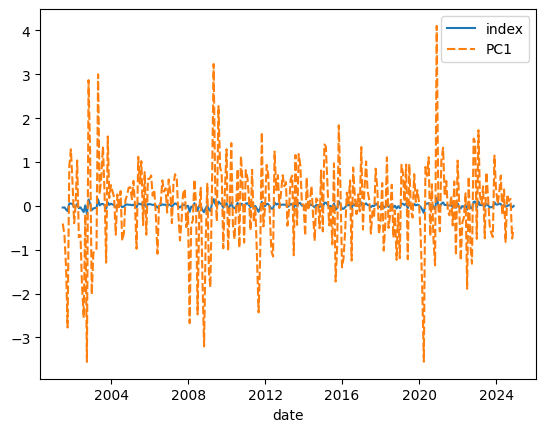

In [92]:
sns.lineplot(index.with_columns(pc1).to_pandas().set_index('date'))

We can clearly see that the volatilities don't match, therefore we can then rescale the principal component to the same volatility as that of the benchmark.

We have

In [93]:
print(f"Principal component std : {pc1.std()} \nIndex std : {index.select('index').std().to_series().to_list()[0]}")

Principal component std : 1.0017777791811964 
Index std : 0.05220421089896673


In [94]:
pc1 = pl.DataFrame(pc1).select(pl.col('PC1').mul(index.select('index').std().to_series().to_list()[0]/pc1.std()))

Text(0.5, 1.0, 'Principal component and Index')

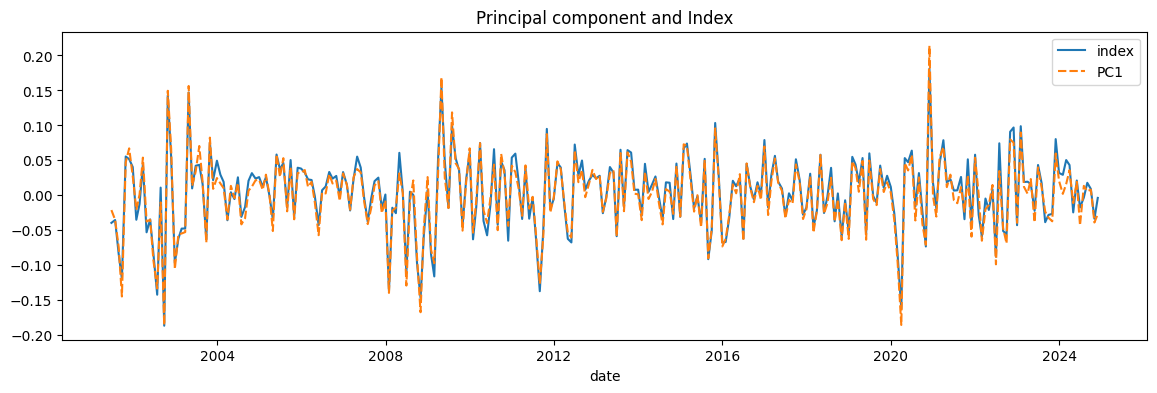

In [95]:
plt.figure(figsize=(14,4))
sns.lineplot(index.with_columns(pc1).to_pandas().set_index('date'))
plt.title('Principal component and Index')

We then regress each stock returns on this principal component, using multiple linear regressions
For this we define a function that applied a linear regression and returns the beta, and we apply it to each column of the stocks dataframe

In [98]:
def get_beta(col_name: str) -> float:
    model = LinearRegression()
    model.fit(X=np.array(pc1.to_series().to_list()).reshape(-1,1), y=stocks.select(col_name).to_series().to_list())
    return float(model.coef_[0])

We start by testing with the first stock:

In [99]:
print("The first stock is", stocks.drop('date').columns[0], f"\nIts beta is {get_beta(stocks.drop('date').columns[0])}")

The first stock is ANHEUSER-BUSCH INBEV SA/NV 
Its beta is 0.7007734180252085


We then define a function to parralelize the calls so that the code is more efficient (not necessary but better practice)

In [100]:
def parralelize_calls(data: pl.DataFrame) -> dict:
    results = {}
    with ThreadPoolExecutor() as executor:
        future_to_col = {executor.submit(get_beta, col_name): col_name for col_name in data.columns}
        for future in as_completed(future_to_col):
            col_name = future_to_col[future]
            try:
                results[col_name.lstrip(' ').split(' ')[0]] = future.result()
            except Exception as exc:
                print(f'{col_name} generated an exception: {exc}')
    return results

In [101]:
betas = parralelize_calls(stocks.drop('date'))

We can then plot the rough results to see where the values are

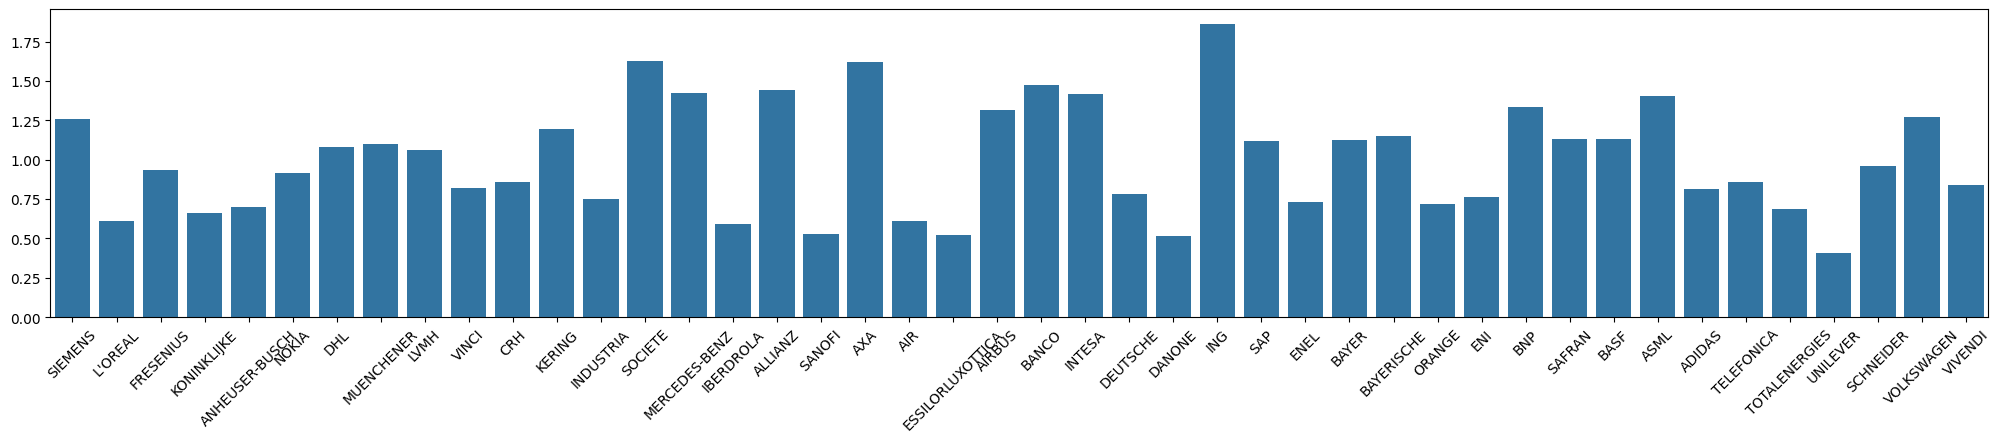

In [102]:
plt.figure(figsize=(25,4))
sns.barplot(betas)
ticks = plt.xticks(rotation=45) 
del ticks